##                                                                     Summary
### Objective
* #### This projects proposes a supervised predicition algorithm of installatino and clicking probabilities based on data from Terragon's database.
### Results
* #### The best performing model of the 6 trained was LGBMClassifier with f1_score = 0.76 on the validation set.
### Limitations
* #### Not enough domain knowledge about the telecoms industry pricing to adequately remove outliers from other numeric fields apart from "age" field.
* #### Working with 100%(65000) of the train dataset yielded mauvaise performance for the Boosting algorithms used thus about 19,000 unique and fairly engineered points were used.
* #### gpu limitations with training model, 500 iterations took about 4 hours with CPU;(device parameters for LGBM GPU-support don't speed up training times).
### Further work would involve:
* #### using "spent_actual" i.e summation of all the telecoms' service categories as a feature in addition to other polynomial features.
* #### obtaining more unique samples from the train dataset and combining performance improvements from each unique training in a "pipeline".
* #### exploring the performance of "Anomaly Detection Classifiers" on 100% of the train dataset.

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_rows", None, "display.max_columns", None)

# 2. Importing datasets

In [2]:

train = pd.read_csv("Train.csv", parse_dates=['timestamp'])
positive = train.loc[(train['event_type'] == 'install')].reset_index(drop = True)
negative = train.loc[(train['event_type'] == 'click')].reset_index(drop = True)
negative=negative.sample(frac = 0.26)

train = pd.concat([positive,negative]).reset_index(drop = True)


test = pd.read_csv("Test.csv", parse_dates=['timestamp'])

## User Defined Functions

In [3]:
def quality_report(df):
    """
    Description: Displays quality of data in terms of missing values, 
    unique numbers, datatypes etc.
    
    Arguments: Dataframe
    """
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    quality_df  = pd.concat([total, percent, nuniq, dtypes], axis=1, keys=['Total NaN', 'Percent of NaN','Nunique', 'Dtype'])
    display(quality_df)


def object_count_plot(df):
    """Description : Plot countplot for all categorical features present in the dataframe passed Argument : Dataframe"""
    for var in df.columns:
        if df[var].dtype == 'object':
            print(df[var].value_counts())
            plt.figure(figsize=(12,5))
            g = sns.countplot(x=var,data=df)
            g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
            plt.tight_layout()
            plt.show()
            
        
def numeric_distribution_plot(df):
    """Description : Gives distribution plot for all the numeric featuresin the dataframe passedArgument : Dataframe"""
    for col in df.columns:
        if df[col].dtype != 'object':
            print(df[col].describe())
            plt.figure(figsize=(12,5))
            plt.title("Distribution of "+col)
            ax = sns.distplot(df[col].dropna())
            plt.tight_layout()
            plt.show()
            value_counts = df[col].value_counts().rename_axis("unique_"+col).to_frame('counts').sort_values('counts',ascending=False)
            print(value_counts.head(5),'\n',value_counts.tail(10))
            sns.boxplot(train[col])    




            
def fill_numeric_median(df):
    """
    Description : Replaces missing values for all the numeric features with the median
    in the dataframe passed
    
    Argument : Dataframe
    """
    for col in df.columns:
        if df[col].dtype != 'object':
            df[col].fillna(df[col].median(), inplace=True)
#remember to fill for test too

def fill_my_categoricals(df):
    """
    Description : Replaces missing values for all the categorical features with None
    in the dataframe passed
    
    Argument : Dataframe
    """
    for col in df.columns:
        if df[col].dtype != 'float64':
            df[col].fillna("None",inplace = True)
#remember to fill test too

# 3. Quick EDA

In [4]:
quality_report(train)

,Total NaN,Percent of NaN,Nunique,Dtype
spend_vas,4504,23.968921,841,float64
sms_cost,4504,23.968921,889,float64
spend_voice,4504,23.968921,9830,float64
spend_data,4504,23.968921,701,float64
location_region,1592,8.472141,6,object
location_state,1592,8.472141,37,object
location_lga,1141,6.072056,659,object
device_type,412,2.192539,2,object
os_vendor,379,2.016923,125,object
os_name,378,2.011601,89,object


<AxesSubplot:xlabel='event_type', ylabel='count'>

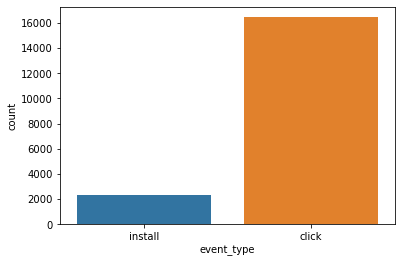

In [5]:
sns.countplot(train['event_type'])

count    1.852500e+04
mean     1.561829e+12
std      8.231670e+08
min      1.558113e+12
25%      1.561378e+12
50%      1.561991e+12
75%      1.562241e+12
max      1.562597e+12
Name: timeline, dtype: float64


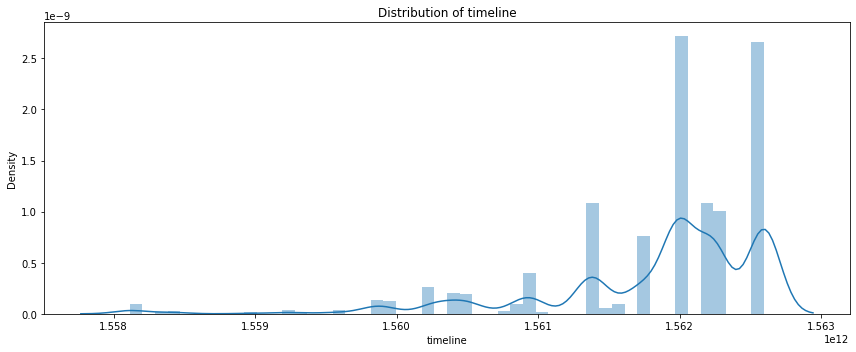

                 counts
unique_timeline        
1.562597e+12       2768
1.561991e+12       2656
1.561990e+12       1856
1.562234e+12       1795
1.562241e+12       1666 
                  counts
unique_timeline        
1.561558e+12          2
1.559834e+12          1
1.559920e+12          1
1.559836e+12          1
1.558366e+12          1
1.559576e+12          1
1.559929e+12          1
1.560527e+12          1
1.559834e+12          1
1.559576e+12          1
count    1.870500e+04
mean     5.479894e+03
std      2.709668e+04
min      0.000000e+00
25%      3.274000e+02
50%      1.569550e+03
75%      4.803400e+03
max      1.535133e+06
Name: spend_total, dtype: float64


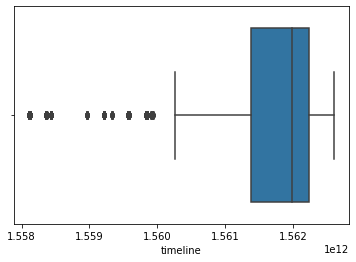

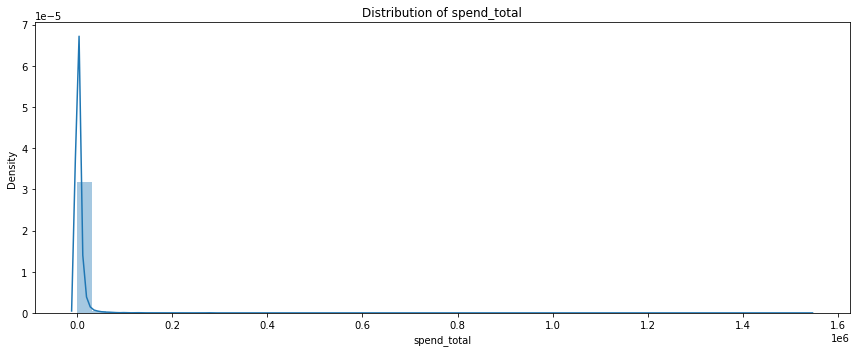

                    counts
unique_spend_total        
0.0                   2118
1000.0                  44
100.0                   42
200.0                   41
1200.0                  19 
                     counts
unique_spend_total        
2087.0500                1
4355.6800                1
3087.8000                1
200.2400                 1
9846.1315                1
17095.2600               1
379.9000                 1
10306.7100               1
607.8350                 1
2693.3200                1
count     14287.000000
mean        302.075103
std        1238.807919
min           0.000000
25%           0.000000
50%          20.000000
75%         250.000000
max      104550.000000
Name: spend_vas, dtype: float64


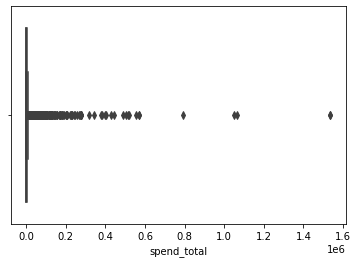

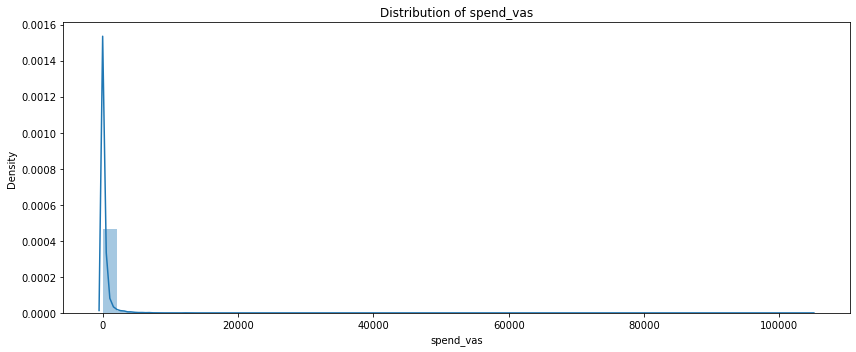

                  counts
unique_spend_vas        
0.0                 6646
100.0                593
50.0                 509
150.0                247
200.0                244 
                   counts
unique_spend_vas        
6825.0                 1
809.0                  1
322.0                  1
945.0                  1
1640.0                 1
2850.0                 1
1185.0                 1
2815.0                 1
685.0                  1
4325.0                 1
count    14287.000000
mean        74.741785
std        260.049426
min          0.000000
25%          0.000000
50%          4.000000
75%         52.000000
max      11837.000000
Name: sms_cost, dtype: float64


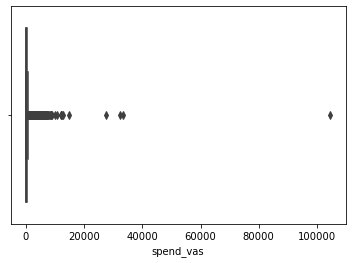

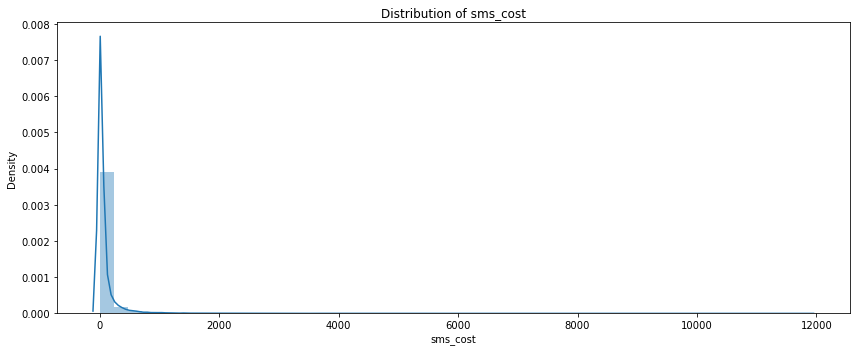

                 counts
unique_sms_cost        
0.0                6318
4.0                 994
8.0                 657
12.0                430
16.0                382 
                  counts
unique_sms_cost        
477.600               1
459.000               1
6.300                 1
51.600                1
366.000               1
195.000               1
419.600               1
274.185               1
1.805                 1
1174.000              1
count    14287.000000
mean      1749.165882
std       3141.274975
min          0.000000
25%         10.330000
50%        570.240000
75%       2043.890000
max      44156.500000
Name: spend_voice, dtype: float64


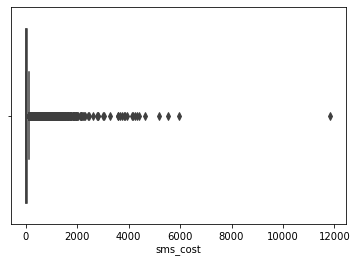

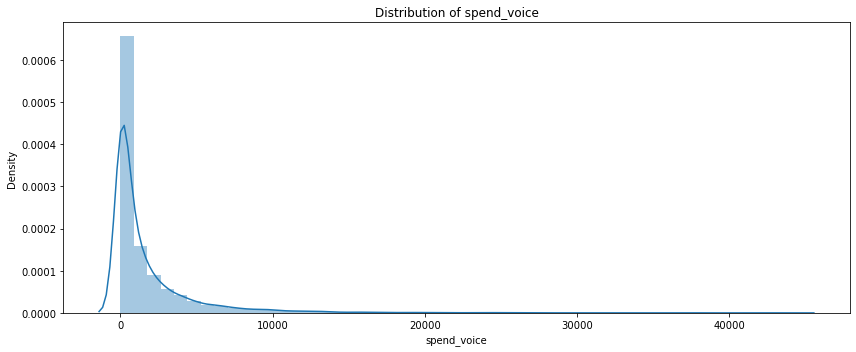

                    counts
unique_spend_voice        
0.0                   3273
100.0                   44
200.0                   19
50.0                    15
10.0                    14 
                     counts
unique_spend_voice        
10677.875                1
2905.200                 1
752.000                  1
253.800                  1
207.220                  1
12.760                   1
650.955                  1
971.330                  1
16111.640                1
3077.270                 1
count    14287.000000
mean       478.884690
std       1114.601939
min          0.000000
25%          0.000000
50%          0.000000
75%        500.000000
max      22500.000000
Name: spend_data, dtype: float64


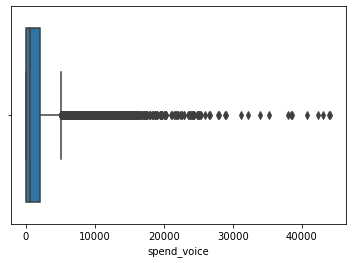

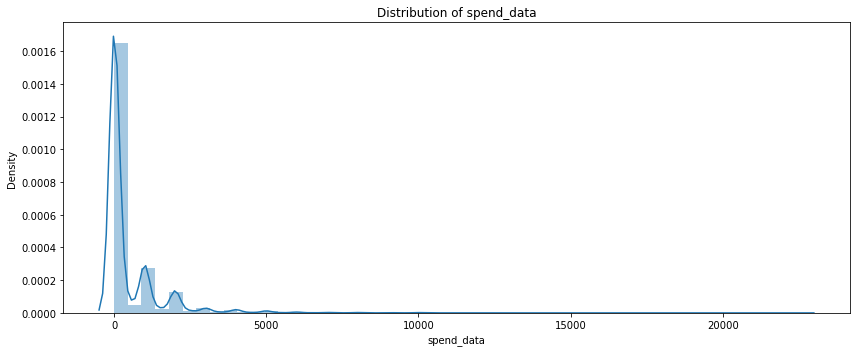

                   counts
unique_spend_data        
0.0                  9015
1000.0               1461
2000.0                681
60.0                  278
100.0                 138 
                    counts
unique_spend_data        
55.110                  1
101.516                 1
3975.000                1
0.950                   1
48.250                  1
7.430                   1
9.200                   1
185.385                 1
5800.000                1
1240.000                1
count    18705.000000
mean        63.223577
std         83.881492
min         19.000000
25%         44.000000
50%         46.000000
75%         46.000000
max       1051.000000
Name: customer_class, dtype: float64


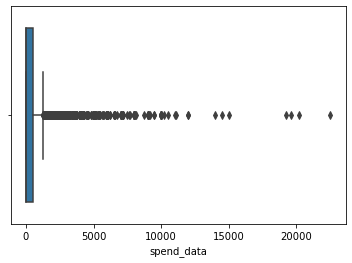

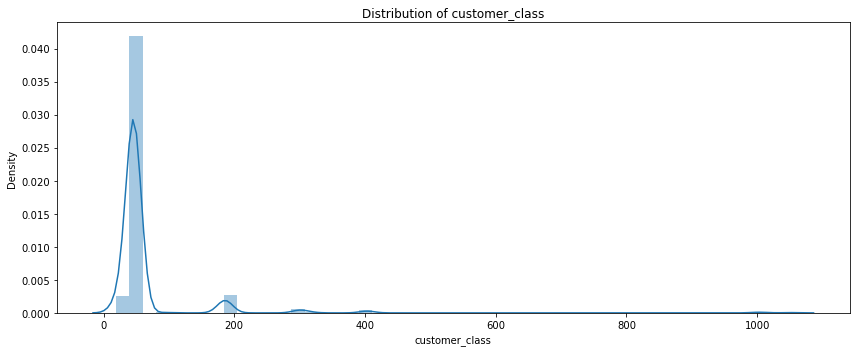

                       counts
unique_customer_class        
46.0                     7786
44.0                     4502
49.0                     3004
42.0                      872
186.0                     760 
                        counts
unique_customer_class        
95.0                        9
97.0                        8
302.0                       6
25.0                        5
402.0                       4
20.0                        2
317.0                       2
412.0                       2
79.0                        1
184.0                       1
count    18706.000000
mean        41.089169
std        101.137801
min          0.000000
25%         27.000000
50%         34.000000
75%         43.000000
max       2020.000000
Name: age, dtype: float64


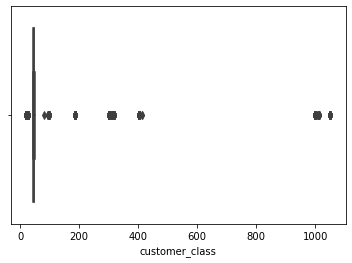

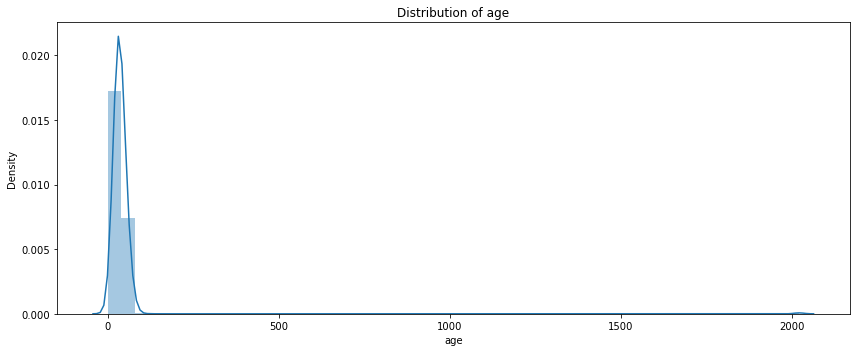

            counts
unique_age        
24.0           704
27.0           655
34.0           645
23.0           643
30.0           640 
             counts
unique_age        
87.0             1
111.0            1
86.0             1
120.0            1
99.0             1
112.0            1
101.0            1
16.0             1
97.0             1
91.0             1


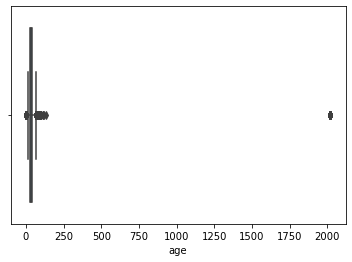

In [6]:
numeric_distribution_plot(train)

In [7]:
train.shape

(18791, 23)

In [8]:
#train = train.drop(train.loc[train['timeline'] < 1.559834e+12].index)
#train.shape

In [9]:
#train = train.drop(train.loc[train['spend_total']>1.5e+6].index)
#train.shape

In [10]:
#train = train.drop(train.loc[train['spend_vas']>50000].index)
#train.shape

In [11]:
#train = train.drop(train.loc[train['sms_cost']>10000].index)
#train.shape

In [12]:
#train = train.drop(train.loc[train['spend_voice']>60000].index)
#train.shape

In [13]:
#train = train.drop(train.loc[train['spend_data']>19000].index)
#train.shape

In [14]:
#train = train.drop(train.loc[train['customer_class']>600].index)
#train.shape

In [15]:
#train = train.drop(train.loc[train['age']>100].index)
#train.shape

In [16]:
#train.shape

<AxesSubplot:xlabel='event_type', ylabel='count'>

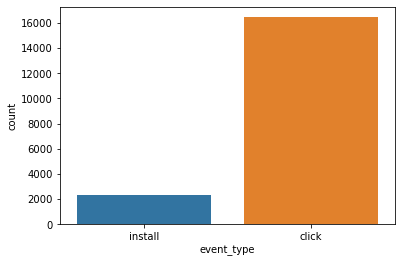

In [17]:
sns.countplot(train['event_type'])

In [18]:
train.describe()

,timeline,spend_total,spend_vas,sms_cost,spend_voice,spend_data,customer_class,age
count,1.852500e+04,1.870500e+04,14287.000000,14287.000000,14287.000000,14287.000000,18705.000000,18706.000000
mean,1.561829e+12,5.479894e+03,302.075103,74.741785,1749.165882,478.884690,63.223577,41.089169
std,8.231670e+08,2.709668e+04,1238.807919,260.049426,3141.274975,1114.601939,83.881492,101.137801
min,1.558113e+12,0.000000e+00,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
25%,1.561378e+12,3.274000e+02,0.000000,0.000000,10.330000,0.000000,44.000000,27.000000
50%,1.561991e+12,1.569550e+03,20.000000,4.000000,570.240000,0.000000,46.000000,34.000000
75%,1.562241e+12,4.803400e+03,250.000000,52.000000,2043.890000,500.000000,46.000000,43.000000
max,1.562597e+12,1.535133e+06,104550.000000,11837.000000,44156.500000,22500.000000,1051.000000,2020.000000


In [19]:
#sns.boxplot(grubbs.test(train['age'],alpha=.05))

In [20]:
#numeric_distribution_plot(test)

In [21]:
test.describe()

,timeline,spend_total,spend_vas,sms_cost,spend_voice,spend_data,customer_class,age
count,5.936000e+03,5962.000000,4441.000000,4441.000000,4441.000000,4441.000000,5962.000000,5962.000000
mean,1.561909e+12,4186.080074,263.353637,57.356201,1506.574206,433.622879,64.135693,41.478698
std,8.645238e+08,11597.952072,1078.010972,196.506736,2856.574220,1035.525044,85.590881,106.574919
min,1.558113e+12,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
25%,1.561736e+12,273.317499,0.000000,0.000000,0.400000,0.000000,44.000000,26.000000
50%,1.562241e+12,1355.950000,2.000000,4.000000,452.550000,0.000000,46.000000,34.000000
75%,1.562597e+12,4156.850000,210.000000,40.000000,1705.525000,350.000000,46.000000,43.000000
max,1.562597e+12,376652.377000,55066.000000,3725.000000,45218.250000,22500.000000,1051.000000,2020.000000


# 4. Data Preprocessing

## Filling Missing Values

In [22]:
#missing numerical values 
fill_numeric_median(train)
fill_numeric_median(test)


In [23]:
#missing categorical values 
fill_my_categoricals(train)
fill_my_categoricals(test)

## Label Encoding

In [24]:
#transforming the 'timeline' columns into gaussian distibution - NOT NEEDED FOR TREE BASED MODELS 
#train['timeline'] = np.log(train['timeline']).values
#test['timeline'] = np.log(test['timeline']).values


#label encoding the categorical variables: device_type, gender,customer_value,has_bank,ad_text, [event_type]

field_map=[]
#manual mapping 
fields = ['device_type', 'gender','customer_value','has_bank',
          'ad_text','location_state','location_region','location_lga',
          'os_vendor','os_name','device_model','device_manufacturer']
for col in fields:
    categories = list(train[col].unique())
    
    cola = {}
    i = 1
    for key in categories:
        cola[key] = i
        i += 1
    field_map.append(cola)

device_type=field_map[0]
gender= field_map[1]
customer_value= field_map[2]
has_bank= field_map[3]
ad_text= field_map[4]
location_state=field_map[5]
location_region=field_map[6]
location_lga=field_map[7]
os_vendor=field_map[8]
os_name=field_map[9]
device_model=field_map[10]
device_manufacturer=field_map[10]


#transforming for the test and train 
train.device_type = train.device_type.map(device_type).astype(float)
train.gender = train.gender.map(gender).astype(float)
train.customer_value = train.customer_value.map(customer_value).astype(float)
train.has_bank = train.has_bank.map(has_bank).astype(float)
train.ad_text = train.ad_text.map(ad_text).astype(float)

test.device_type = test.device_type.map(device_type).astype(float)
test.gender = test.gender.map(gender).astype(float)
test.customer_value = test.customer_value.map(customer_value).astype(float)
test.has_bank = test.has_bank.map(has_bank).astype(float)
test.ad_text = test.ad_text.map(ad_text).astype(float)




#for far too great classes
le = LabelEncoder()
for col in (train.drop(['msisdn','timestamp'],axis =1,inplace =False).columns):
        if train[col].dtype == 'object':
            train[col]=le.fit_transform(train[col]).astype(float)

            le = LabelEncoder()
for col in (test.drop(['msisdn','timestamp'],axis =1,inplace =False).columns):
        if test[col].dtype != 'float64':
            test[col]=le.fit_transform(test[col]).astype(float)

#remember to fill test too

#need to clean the timestamp 
quality_report(train)

,Total NaN,Percent of NaN,Nunique,Dtype
msisdn,0,0.0,18328,object
age,0,0.0,86,float64
os_vendor,0,0.0,126,float64
device_type,0,0.0,3,float64
device_model,0,0.0,2292,float64
device_manufacturer,0,0.0,275,float64
location_lga,0,0.0,660,float64
location_state,0,0.0,38,float64
location_region,0,0.0,7,float64
has_bank,0,0.0,3,float64


In [25]:

train.head(10)

,msisdn,timeline,timestamp,event_type,ad_text,spend_total,spend_vas,sms_cost,spend_voice,spend_data,customer_class,customer_value,age,gender,has_bank,location_region,location_state,location_lga,device_manufacturer,device_model,device_type,os_vendor,os_name
0,b0c89e6222030d07623bbdfcd802068a,1.560529e+12,2019-07-01 20:01:54+00:00,1.0,1.0,2098.4000,0.0,0.0,0.00,0.0,19.0,1.0,30.0,1.0,1.0,5.0,3.0,527.0,227.0,502.0,1.0,53.0,14.0
1,8dbe350a0864243bcbcab192c11afb1c,1.561370e+12,2019-07-27 12:45:55+00:00,1.0,2.0,5361.8000,510.0,156.0,2933.86,2000.0,42.0,2.0,33.0,1.0,1.0,6.0,25.0,279.0,173.0,11.0,2.0,108.0,70.0
2,e9494ef7df151115dd00cb9e0cd75b28,1.559919e+12,2019-06-09 09:13:49,1.0,3.0,6000.2600,240.0,24.0,2545.11,1000.0,46.0,2.0,43.0,1.0,1.0,6.0,25.0,384.0,173.0,88.0,1.0,53.0,14.0
3,3b17282522ff95f763243d9a87f25e01,1.562241e+12,2019-07-08 17:55:46+00:00,1.0,4.0,4202.0000,0.0,24.0,1098.80,0.0,49.0,1.0,46.0,1.0,1.0,4.0,1.0,2.0,227.0,1311.0,1.0,53.0,14.0
4,e14725c65cb0a904d83fa6d5990244d6,1.561736e+12,2019-07-03 17:56:12+00:00,1.0,1.0,434.4400,0.0,0.0,0.00,0.0,46.0,3.0,42.0,1.0,1.0,4.0,17.0,545.0,227.0,523.0,1.0,53.0,14.0
5,f1e1a3a9e5c0493ce20dd9a7b039b37b,1.561370e+12,2019-06-24 16:56:08+00:00,1.0,2.0,2961.8100,0.0,100.0,1583.98,0.0,319.0,1.0,2020.0,1.0,2.0,5.0,33.0,559.0,202.0,1802.0,1.0,100.0,61.0
6,04713af0f76196b13b1503054b263988,1.562597e+12,2019-07-12 19:30:57+00:00,1.0,4.0,2948.1195,160.0,0.0,1055.20,0.0,44.0,1.0,30.0,1.0,1.0,6.0,25.0,43.0,260.0,1727.0,1.0,53.0,14.0
7,dc444cc5da68b577da28fb2e9c998b31,1.562241e+12,2019-07-07 16:22:16+00:00,1.0,4.0,12769.6400,1541.0,0.0,1268.50,0.0,44.0,4.0,31.0,1.0,1.0,3.0,34.0,600.0,23.0,1765.0,2.0,93.0,57.0
8,cdbabe11ed501e04b0c3a0fed58806f1,1.562241e+12,2019-07-07 05:19:08+00:00,1.0,4.0,200.0000,20.0,4.0,570.24,0.0,46.0,5.0,33.0,1.0,1.0,6.0,30.0,146.0,227.0,1659.0,1.0,53.0,14.0
9,b0afeb52e166d7d6314ba57a166e682a,1.558969e+12,2019-05-31 07:26:28,1.0,5.0,8155.4090,260.0,0.0,225.90,2000.0,49.0,2.0,53.0,1.0,1.0,6.0,25.0,592.0,123.0,230.0,1.0,53.0,14.0


## Extracting date features

In [26]:
#for dates - train
train["timestamp"] = pd.to_datetime(train["timestamp"],utc =True)

dates = []
for i in train["timestamp"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

#for dates - test
test["timestamp"] = pd.to_datetime(test["timestamp"],utc =True)




The newest customer's enrolment date in therecords: 2020-12-24
The oldest customer's enrolment date in the records: 2019-05-18


In [27]:
quality_report(train)

,Total NaN,Percent of NaN,Nunique,Dtype
msisdn,0,0.0,18328,object
age,0,0.0,86,float64
os_vendor,0,0.0,126,float64
device_type,0,0.0,3,float64
device_model,0,0.0,2292,float64
device_manufacturer,0,0.0,275,float64
location_lga,0,0.0,660,float64
location_state,0,0.0,38,float64
location_region,0,0.0,7,float64
has_bank,0,0.0,3,float64


In [28]:
train.head(3)

,msisdn,timeline,timestamp,event_type,ad_text,spend_total,spend_vas,sms_cost,spend_voice,spend_data,customer_class,customer_value,age,gender,has_bank,location_region,location_state,location_lga,device_manufacturer,device_model,device_type,os_vendor,os_name
0,b0c89e6222030d07623bbdfcd802068a,1.560529e+12,2019-07-01 20:01:54+00:00,1.0,1.0,2098.40,0.0,0.0,0.00,0.0,19.0,1.0,30.0,1.0,1.0,5.0,3.0,527.0,227.0,502.0,1.0,53.0,14.0
1,8dbe350a0864243bcbcab192c11afb1c,1.561370e+12,2019-07-27 12:45:55+00:00,1.0,2.0,5361.80,510.0,156.0,2933.86,2000.0,42.0,2.0,33.0,1.0,1.0,6.0,25.0,279.0,173.0,11.0,2.0,108.0,70.0
2,e9494ef7df151115dd00cb9e0cd75b28,1.559919e+12,2019-06-09 09:13:49+00:00,1.0,3.0,6000.26,240.0,24.0,2545.11,1000.0,46.0,2.0,43.0,1.0,1.0,6.0,25.0,384.0,173.0,88.0,1.0,53.0,14.0


In [29]:
test.columns

Index(['msisdn', 'timeline', 'timestamp', 'ad_text', 'spend_total',
       'spend_vas', 'sms_cost', 'spend_voice', 'spend_data', 'customer_class',
       'customer_value', 'age', 'gender', 'has_bank', 'location_region',
       'location_state', 'location_lga', 'device_manufacturer', 'device_model',
       'device_type', 'os_vendor', 'os_name'],
      dtype='object')

In [30]:
train.columns

Index(['msisdn', 'timeline', 'timestamp', 'event_type', 'ad_text',
       'spend_total', 'spend_vas', 'sms_cost', 'spend_voice', 'spend_data',
       'customer_class', 'customer_value', 'age', 'gender', 'has_bank',
       'location_region', 'location_state', 'location_lga',
       'device_manufacturer', 'device_model', 'device_type', 'os_vendor',
       'os_name'],
      dtype='object')

## Merging both test and train datasets for uniform feature engineering

In [31]:

test['event_type'] = 'test'
data = pd.concat([train, test]).reset_index(drop = True)

#data[65589:65594]

In [32]:
quality_report(data)

,Total NaN,Percent of NaN,Nunique,Dtype
ad_text,1,0.004034,57,float64
msisdn,0,0.000000,22779,object
age,0,0.000000,90,float64
os_vendor,0,0.000000,126,float64
device_type,0,0.000000,3,float64
device_model,0,0.000000,2292,float64
device_manufacturer,0,0.000000,275,float64
location_lga,0,0.000000,660,float64
location_state,0,0.000000,38,float64
location_region,0,0.000000,7,float64


# 5. Feature Engineering

In [33]:
data['timestamp'] = pd.to_datetime(data.timestamp,utc = True)

In [34]:
max(data.timestamp)

Timestamp('2020-12-24 06:05:55+0000', tz='UTC')

In [35]:
data['year'] = data.timestamp.dt.year
data['month'] = data.timestamp.dt.month
data['quater'] = data.timestamp.dt.quarter


today = pd.to_datetime(pd.Timestamp(year = 2021,  month = 1, day = 1,
                  hour = 0, second = 0, tz = 'UTC'))

data['duration_days'] = (today - data['timestamp']).dt.days
data['duration_months'] = ((today- data.timestamp)/np.timedelta64(1, 'M'))
data['duration_months'] = data['duration_months'].astype(int)

data['is_month_end'] = data.timestamp.dt.is_month_end.astype(int)
data['is_month_start'] = data.timestamp.dt.is_month_start.astype(int)

In [36]:
#data['total_children'] = data['No_of_Kids_in_home'] + data['No_of_Teen_in_home']

In [37]:
poly_feature_1 = ['spend_vas', 'sms_cost', 'spend_voice', 'spend_data']
poly_feature_2 = ['location_region', 'location_state', 'location_lga']
poly_feature_3 = ['device_manufacturer', 'device_model', 'device_type','os_vendor','os_name']


In [38]:
from sklearn.preprocessing import PolynomialFeatures

In [39]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

poly1 = poly.fit_transform(data[poly_feature_1])
poly2 = poly.fit_transform(data[poly_feature_2])
poly3 = poly.fit_transform(data[poly_feature_3])


In [40]:
df_poly1 = pd.DataFrame(poly1, columns=[f"poly1_{i}" for i in range(poly1.shape[1])])
df_poly2 = pd.DataFrame(poly2, columns=[f"poly2_{i}" for i in range(poly2.shape[1])])
df_poly3 = pd.DataFrame(poly3, columns=[f"poly3_{i}" for i in range(poly3.shape[1])])




In [41]:
data.columns

Index(['msisdn', 'timeline', 'timestamp', 'event_type', 'ad_text',
       'spend_total', 'spend_vas', 'sms_cost', 'spend_voice', 'spend_data',
       'customer_class', 'customer_value', 'age', 'gender', 'has_bank',
       'location_region', 'location_state', 'location_lga',
       'device_manufacturer', 'device_model', 'device_type', 'os_vendor',
       'os_name', 'year', 'month', 'quater', 'duration_days',
       'duration_months', 'is_month_end', 'is_month_start'],
      dtype='object')

In [42]:
new_data = pd.concat([data, df_poly1], axis = 1)
new_data = pd.concat([new_data, df_poly2], axis = 1)
new_data = pd.concat([new_data, df_poly3], axis = 1)



In [43]:
new_data['telecoms_spend'] = new_data[poly_feature_1].sum(axis = 1)
new_data['geography'] = new_data[poly_feature_2].sum(axis = 1)
new_data['sevice_build'] = new_data[poly_feature_3].sum(axis = 1)


In [44]:
new_data['year_month'] = new_data['year'].apply(str) + "_"  + new_data['month'].apply(str)

In [45]:
# bin_label = [1,2,3,4,5]
new_data['customer_class'] = pd.qcut(new_data.customer_class, q = [0, .2, .4, .6, .8, 1],duplicates='drop', labels=False)

In [46]:
#grouping attributes of spend_total of costumers by time periods
new_data['spend_total' + '_mean_on_yr_mth'] = new_data['spend_total'].groupby(new_data['year_month']).transform('mean')
new_data['spend_total' + '_std_on_yr_mth'] = new_data['spend_total'].groupby(new_data['year_month']).transform('std')
new_data['spend_total' + '_max_on_yr_mth'] = new_data['spend_total'].groupby(new_data['year_month']).transform('max')
new_data['spend_total' + '_min_on_yr_mth'] = new_data['spend_total'].groupby(new_data['year_month']).transform('min')

In [47]:
new_data['year_month_int'], _ = pd.factorize(new_data['year_month'])

In [48]:
new_data.columns

Index(['msisdn', 'timeline', 'timestamp', 'event_type', 'ad_text',
       'spend_total', 'spend_vas', 'sms_cost', 'spend_voice', 'spend_data',
       'customer_class', 'customer_value', 'age', 'gender', 'has_bank',
       'location_region', 'location_state', 'location_lga',
       'device_manufacturer', 'device_model', 'device_type', 'os_vendor',
       'os_name', 'year', 'month', 'quater', 'duration_days',
       'duration_months', 'is_month_end', 'is_month_start', 'poly1_0',
       'poly1_1', 'poly1_2', 'poly1_3', 'poly1_4', 'poly1_5', 'poly1_6',
       'poly1_7', 'poly1_8', 'poly1_9', 'poly2_0', 'poly2_1', 'poly2_2',
       'poly2_3', 'poly2_4', 'poly2_5', 'poly3_0', 'poly3_1', 'poly3_2',
       'poly3_3', 'poly3_4', 'poly3_5', 'poly3_6', 'poly3_7', 'poly3_8',
       'poly3_9', 'poly3_10', 'poly3_11', 'poly3_12', 'poly3_13', 'poly3_14',
       'telecoms_spend', 'geography', 'sevice_build', 'year_month',
       'spend_total_mean_on_yr_mth', 'spend_total_std_on_yr_mth',
       'spend_

In [49]:
features = new_data.select_dtypes(include = 'number').columns

In [50]:
train_df = new_data.loc[(new_data['event_type'] != 'test')].reset_index(drop = True)
test_df = new_data.loc[(new_data['event_type'] == 'test')].reset_index(drop = True)

In [51]:
#test_df.head(5)

In [52]:
new_data.head(3)

,msisdn,timeline,timestamp,event_type,ad_text,spend_total,spend_vas,sms_cost,spend_voice,spend_data,customer_class,customer_value,age,gender,has_bank,location_region,location_state,location_lga,device_manufacturer,device_model,device_type,os_vendor,os_name,year,month,quater,duration_days,duration_months,is_month_end,is_month_start,poly1_0,poly1_1,poly1_2,poly1_3,poly1_4,poly1_5,poly1_6,poly1_7,poly1_8,poly1_9,poly2_0,poly2_1,poly2_2,poly2_3,poly2_4,poly2_5,poly3_0,poly3_1,poly3_2,poly3_3,poly3_4,poly3_5,poly3_6,poly3_7,poly3_8,poly3_9,poly3_10,poly3_11,poly3_12,poly3_13,poly3_14,telecoms_spend,geography,sevice_build,year_month,spend_total_mean_on_yr_mth,spend_total_std_on_yr_mth,spend_total_max_on_yr_mth,spend_total_min_on_yr_mth,year_month_int
0,b0c89e6222030d07623bbdfcd802068a,1.560529e+12,2019-07-01 20:01:54+00:00,1.0,1.0,2098.40,0.0,0.0,0.00,0.0,0,1.0,30.0,1.0,1.0,5.0,3.0,527.0,227.0,502.0,1.0,53.0,14.0,2019,7,3,549,18,0,1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,5.0,3.0,527.0,15.0,2635.0,1581.0,227.0,502.0,1.0,53.0,14.0,113954.0,227.0,12031.0,3178.0,502.0,26606.0,7028.0,53.0,14.0,742.0,0.00,535.0,797.0,2019_7,5656.466458,27057.362116,1535133.300,0.0,0
1,8dbe350a0864243bcbcab192c11afb1c,1.561370e+12,2019-07-27 12:45:55+00:00,1.0,2.0,5361.80,510.0,156.0,2933.86,2000.0,0,2.0,33.0,1.0,1.0,6.0,25.0,279.0,173.0,11.0,2.0,108.0,70.0,2019,7,3,523,17,0,0,510.0,156.0,2933.86,2000.0,79560.0,1496268.6,1020000.0,457682.16,312000.0,5867720.0,6.0,25.0,279.0,150.0,1674.0,6975.0,173.0,11.0,2.0,108.0,70.0,1903.0,346.0,18684.0,12110.0,22.0,1188.0,770.0,216.0,140.0,7560.0,5599.86,310.0,364.0,2019_7,5656.466458,27057.362116,1535133.300,0.0,0
2,e9494ef7df151115dd00cb9e0cd75b28,1.559919e+12,2019-06-09 09:13:49+00:00,1.0,3.0,6000.26,240.0,24.0,2545.11,1000.0,1,2.0,43.0,1.0,1.0,6.0,25.0,384.0,173.0,88.0,1.0,53.0,14.0,2019,6,2,571,18,0,0,240.0,24.0,2545.11,1000.0,5760.0,610826.4,240000.0,61082.64,24000.0,2545110.0,6.0,25.0,384.0,150.0,2304.0,9600.0,173.0,88.0,1.0,53.0,14.0,15224.0,173.0,9169.0,2422.0,88.0,4664.0,1232.0,53.0,14.0,742.0,3809.11,415.0,329.0,2019_6,4055.841174,14865.404589,571404.552,0.0,1


In [53]:
train_df['event_type'] = train_df['event_type'].apply(int)

In [54]:
target = 'event_type'

# 6.  Modelling

In [55]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [56]:
X = train_df[features]
X.drop('timeline',axis=1,inplace=True)
y = train_df[target]

In [57]:
X.columns

Index(['ad_text', 'spend_total', 'spend_vas', 'sms_cost', 'spend_voice',
       'spend_data', 'customer_class', 'customer_value', 'age', 'gender',
       'has_bank', 'location_region', 'location_state', 'location_lga',
       'device_manufacturer', 'device_model', 'device_type', 'os_vendor',
       'os_name', 'year', 'month', 'quater', 'duration_days',
       'duration_months', 'is_month_end', 'is_month_start', 'poly1_0',
       'poly1_1', 'poly1_2', 'poly1_3', 'poly1_4', 'poly1_5', 'poly1_6',
       'poly1_7', 'poly1_8', 'poly1_9', 'poly2_0', 'poly2_1', 'poly2_2',
       'poly2_3', 'poly2_4', 'poly2_5', 'poly3_0', 'poly3_1', 'poly3_2',
       'poly3_3', 'poly3_4', 'poly3_5', 'poly3_6', 'poly3_7', 'poly3_8',
       'poly3_9', 'poly3_10', 'poly3_11', 'poly3_12', 'poly3_13', 'poly3_14',
       'telecoms_spend', 'geography', 'sevice_build',
       'spend_total_mean_on_yr_mth', 'spend_total_std_on_yr_mth',
       'spend_total_max_on_yr_mth', 'spend_total_min_on_yr_mth',
       'year_month_

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Models

### MODEL 1 XGBClassifier #Benchmark f1 score 0.450828729281768

In [59]:
#MODEL 1 XGBClassifier #Benchmark f1 score 0.450828729281768

model = XGBClassifier(scale_pos_weight = 8,max_depth = 8, n_estimators = 500)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

#print(f1_score(prediction, y_test))


[15:42:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### MODEL 2 LGBM Classifier with oversampled inputs #Benchmark f1 score 0.4517184942716858

In [60]:
#undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 0)

X_train_res, y_train_res = rus.fit_resample(X_train, y_train)




In [61]:
#oversampling
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [62]:
#MODEL 2 LGBM Classifier with oversampled inputs #Benchmark f1 score 0.4517184942716858

model = LGBMClassifier(scale_pos_weight = 8,max_depth=6, n_estimators = 1000, learning_rate=0.01)
model.fit(X_train_res, y_train_res)
prediction = model.predict(X_test)

#print(f1_score(prediction, y_test))


### MODEL 3 CatBoostClassifier no sampling #Benchmark f1 score 0.3827314238273142

In [63]:
#MODEL 3 CatBoostClassifier no sampling #Benchmark f1 score 0.3827314238273142
#model = CatBoostClassifier(scale_pos_weight = 27,max_depth=6, n_estimators = 1000, learning_rate=0.01)
#model.fit(X_train_res, y_train_res)
#prediction = model.predict(X_test)

#print(f1_score(prediction, y_test))


## Modelling with SMOTE

In [64]:
 print(train_df['event_type'].value_counts())

0    16443
1     2348
Name: event_type, dtype: int64


In [65]:
from imblearn.over_sampling import SMOTE
sm =SMOTE(sampling_strategy={1:5000, 0:16443},random_state=2021)
X_, y_ = sm.fit_resample(train_df[features], train_df[target])

### MODEL 4 lgbm_cat_5fold sampling #Benchmark f1 score 0.7361616642682244

In [66]:
#MODEL 4 lgb_cat_5fold sampling #Benchmark f1 score 0.7361616642682244
oof_f1=[]
oof_predictions=[]

params = {'learning_rate': 0.3,
         'subsample': 0.7845527188607021,
         'colsample_bytree': 0.6474680443294045,
         'max_depth': 8,
         'scale_pos_weight': 27}

fold=StratifiedKFold(n_splits=5)#15#5#10

i=1
for train_index, test_index in fold.split(X_,y_):
        
    X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]

    model = LGBMClassifier(**params, n_estimators=1000)

    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100
    preds=model.predict(X_test)

    print(f'F1, fold {i}: {f1_score(y_test,preds)}')
    i+=1                
    oof_f1.append(f1_score(y_test,preds))
    p2 = model.predict_proba(test_df[features])[:,0]
    oof_predictions.append(p2)
    

print(np.mean(oof_f1))

F1, fold 1: 0.6280843427545985
F1, fold 2: 0.6277904328018223
F1, fold 3: 0.771960958296362
F1, fold 4: 0.8292480265891151
F1, fold 5: 0.8533561351004701
0.7420879791084736


In [67]:
#to see the probabilities of getting 0
#p2


#### Feature Importance for model 4 - 4 lgb_cat_5fold

Text(0.5, 1.0, 'Model features importance:')

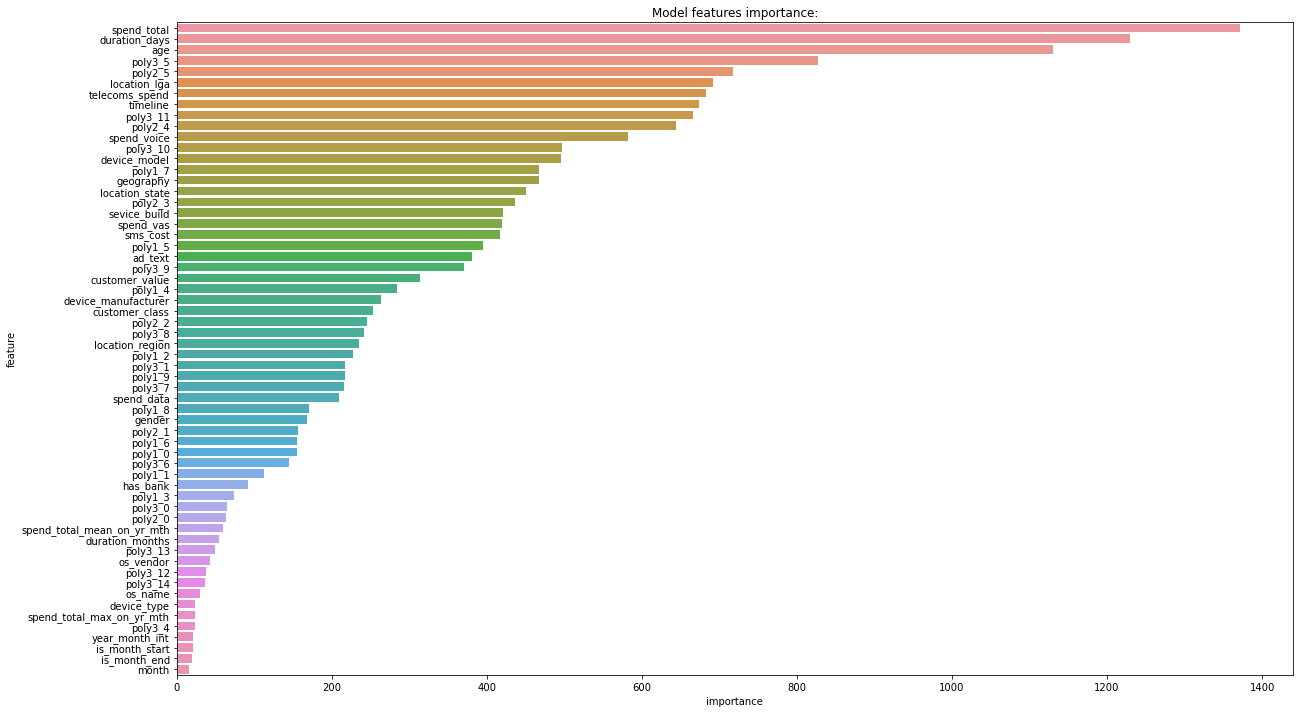

In [68]:
# 0.7831404345536787
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = new_data[features].columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Model features importance:')

#### Feature Selection

In [69]:
#selecting 50 of the most prominent features for visualization
new_feat = feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50)['feature'].to_list()

#### Hyperparameter Tuning with optuna

In [70]:
import optuna

In [71]:
X = train_df[features]
y = train_df[target]

In [72]:
X = train_df[new_feat]

### Model 5 XGboost tuned, f1_score 0.4749944377084578 and Catboost tuned, f1_score 0.38

In [73]:
def objective(trial):
    oof_f1=[]
    oof_predictions=[]


    param = {}
#     param['objective'] = "Logloss"
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.1, 0.001)
    param['depth'] = trial.suggest_int('depth', 3, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['iterations'] = trial.suggest_discrete_uniform("iterations", 200, 2000, 50)
    param['use_best_model'] = True
    param["colsample_bylevel"] =  trial.suggest_float("colsample_bylevel", 0.01, 0.1)
    param['random_state'] = 0
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 4, 30)
    param['bootstrap_type'] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    param['logging_level'] = 'Silent'
    param['verbosity'] = 0



    fold=StratifiedKFold(n_splits=5)#15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#       model = CatBoostClassifier(**param)
        model = XGBClassifier(**param)
    

        model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=200, verbose = False)#erly100
        preds=model.predict(X_test)

        oof_f1.append(f1_score(y_test,preds))

    return np.mean(oof_f1)

In [74]:
#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=50)

In [75]:
#obtaining and using the results
#print("Number of finished trials: {}".format(len(study.trials)))

#print("Best trial:")
#trial = study.best_trial

#print("  Value: {}".format(trial.value))

#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

In [76]:
#X = train_df[features]
#X.drop('timeline',axis=1,inplace=True)


### Model 6 - lgbm_5_fold f1_score 0.5023746674310432

In [77]:
#Model 6 - lgbm_5_fold f1_score 0.5023746674310432
def objective(trial):
    oof_f1=[]
    oof_predictions=[]


    param = {}
#     param['objective'] = "Logloss"
#     param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.001, 0.1, 0.001)
#     param['depth'] = trial.suggest_int('depth', 3, 15)
#     param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
#     param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#     param['iterations'] = trial.suggest_discrete_uniform("iterations", 200, 2000, 50)
#     param['use_best_model'] = True
#     param["colsample_bylevel"] =  trial.suggest_float("colsample_bylevel", 0.01, 0.1)
#     param['random_state'] = 0
    
#     param['bootstrap_type'] = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
#     param['logging_level'] = 'Silent'
    
    param["learning_rate"] = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
#     param['reg_lambda'] = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
#     param['reg_alpha'] = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    param['subsample'] = trial.suggest_float("subsample", 0.1, 1.0)
    param['colsample_bytree'] = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    param['max_depth'] = trial.suggest_int("max_depth", 5, 20)
    param['scale_pos_weight'] = trial.suggest_int('scale_pos_weight', 1, 10)
#    param["device"] = "gpu"




    fold=StratifiedKFold(n_splits=5)#15#5#10
    i=1
    for train_index, test_index in fold.split(X,y):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LGBMClassifier(**param ,n_estimators=10000)

    
        model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=300, verbose = False)#erly100
        preds=model.predict(X_test)
        oof_f1.append(f1_score(y_test,preds))

    

    return np.mean(oof_f1)

In [81]:
#please increase the no of tials ,5 used here for illustrative purposes
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

[I 2021-11-16 15:45:51,456] A new study created in memory with name: no-name-e16f863d-e2ce-449f-9c36-6a710381e610
[I 2021-11-16 15:45:59,145] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.04454099998219, 'subsample': 0.3045113121181331, 'colsample_bytree': 0.4421937313723887, 'max_depth': 14, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.0.
[I 2021-11-16 15:46:06,006] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.0376585614070027, 'subsample': 0.9575138315960798, 'colsample_bytree': 0.9248242837877171, 'max_depth': 5, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.0.
[I 2021-11-16 15:46:30,777] Trial 2 finished with value: 0.5091350858245136 and parameters: {'learning_rate': 0.06968282147651161, 'subsample': 0.3348604195895232, 'colsample_bytree': 0.9873698293390533, 'max_depth': 17, 'scale_pos_weight': 4}. Best is trial 2 with value: 0.5091350858245136.
[I 2021-11-16 15:46:46,738] Trial 3 finished with value: 0.52070021045

In [82]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 5
Best trial:
  Value: 0.5207002104559336
  Params: 
    learning_rate: 0.06918507311267345
    subsample: 0.4595801484580895
    colsample_bytree: 0.5940513082967886
    max_depth: 6
    scale_pos_weight: 2


In [83]:
trial.params

{'learning_rate': 0.06918507311267345,
 'subsample': 0.4595801484580895,
 'colsample_bytree': 0.5940513082967886,
 'max_depth': 6,
 'scale_pos_weight': 2}

In [84]:
X_test.shape

(4288, 66)

In [ ]:
#results from previous training based on similar problem 
# Trial 3100 finished with value: 0.9395282013444826 and parameters: {'learning_rate': 0.042, 'depth': 3,
#                                                                   'l2_leaf_reg': 1.5, 'min_child_samples': 8, 
#                                                                   'iterations': 1400.0, 'colsample_bylevel': 0.03307446978765261,
#                                                                   'scale_pos_weight': 4, 'bootstrap_type': 'MVS'}. Best is trial 31 with value: 0.9795282013444826.

In [85]:
param = {'learning_rate': 0.042,
         'min_child_samples': 8,
         'scale_pos_weight': 4,}

### Model 6 - lgbm_5_fold_tuned f1_score 0.768713749702667

In [86]:
oof_f1=[]
lgb_oof_predictions=[]


#param = trial.params



fold=StratifiedKFold(n_splits=5)#15#5#10
i=1

for train_index, test_index in fold.split(X_,y_):
        
    X_train, X_test = X_.iloc[train_index], X_.iloc[test_index]
    y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
    
    model = LGBMClassifier(**param ,n_estimators=10000)

    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)], early_stopping_rounds=500, verbose = False)#erly100
    preds=model.predict(X_test)
    print("f1_score: ",f1_score(y_test,preds))
    oof_f1.append(f1_score(y_test,preds))
    p2 = model.predict_proba(test_df[X_.columns])[:, 1]
    lgb_oof_predictions.append(p2)
    
print(np.mean(oof_f1))

f1_score:  0.6512770137524557
f1_score:  0.6475814412635734
f1_score:  0.8052681091251176
f1_score:  0.868237347294939
f1_score:  0.8828748890860693
0.771047760104431


In [87]:
pred_lgb = pd.DataFrame(lgb_oof_predictions).T

In [88]:
pred_lgb.head()

,0,1,2,3,4
0,0.000105,0.000204,0.000005,5.572495e-07,2.458459e-07
1,0.000193,0.000427,0.000027,8.456977e-07,2.461035e-06
2,0.000274,0.000289,0.000085,1.048033e-05,7.416712e-07
3,0.000497,0.000296,0.000042,3.518571e-06,1.448299e-05
4,0.000333,0.000345,0.000020,1.687224e-04,2.741794e-06


# 7. Prediction

In [98]:
#need to drop timeline in the testdatset here
test_df[features]
test_df[features].drop('timeline',axis=1,inplace=True)
preds=model.predict_proba(test_df[features])[:, 1]


# 8. Submission

In [99]:
#Create submission file using an empty/dummy dataframe
sub_file = pd.DataFrame(columns=['msisdn','probability', 'result'])
sub_file.head()
#Save test ID in a copy for creating submission file later
test_dataset = pd.read_csv('Test.csv')
sub_file.msisdn= test_dataset.msisdn
sub_file.head()
#Save prediction to submission file created earlier
sub_file.probability = preds
#sub_file.head()


In [103]:
#converting results to conform to prediction requirements
sub_file['result'] = np.where(sub_file['probability']>=0.5, 1, 0)

#number of  clicks(0) vs installs(1)

print(sub_file['result'].value_counts())

#submission
sub_file.to_csv('SampleSubmission.csv',index = False,float_format='%.2f')

0    5103
1     896
Name: result, dtype: int64


#                                                                      tl;dr(too long didn't run)
* # The best performing model of the 6 trained was LGBMClassifier with f1_score = 0.76 on the validation set.
# Limitations
* # Not enough domain knowledge about the telecoms industry pricing to adequately remove outliers from other numeric fields apart from "age" field.
* # Working with 100%(65000) of the train dataset yielded mauvaise performance for the Boosting algorithms used thus about 19,000 unique and fairly engineered points were used.
* # gpu limitations with training model, 500 iterations took about 4 hours with CPU;(device parameters for LGBM GPU-support don't speed up training times).
# Further work would involve:
* # using "spent_actual" i.e summation of all the telecoms' service categories as a feature in addition to other polynomial features.
* # obtaining more unique samples from the train dataset and combining performance improvements from each unique training in a "pipeline".
* # exploring the performance of "Anomaly Detection Classifiers" on 100% of the train dataset.
